# 4. Computer Vision and Convolutional Neural Networks in TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognising the car in front.

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

tf.__version__

'2.9.1'

## Architecture of a CNN

|Hyperparameter|What does it do?|Typical Values|
|--------------|----------------|--------------|
|Input Image(s)|Target images you'd like to discover patterns in|Whatever you can take a photo (or video) of|
|Input layer|Takes in target images and preprocesses them for further layers|input_shape = [batch_size, image_height, image_width, color_channels]|
|Convolutional layer|Extracts/learns the most important features from target images|Multiple, can create with `tf.keras.layers.ConvXD` (X can be multiple values)|
|Hidden activation|Adds non-linearity to the learned features (non-straight lines)|Usually ReLU (`tf.keras.activations.relu`)|
|Pooling layer|Reduces the dimensionality of learned image features|Average (`tf.keras.layers.AvgPool2D`) or Max (`tf.keras.layers.MaxPool2D`)|
|Fully connected layer|Further refines learned features from convolutional layers|`tf.keras.layers.Dense`|
|Output layer|Takes learned features and outputs them in shape of target labels|output_shape = [number_of_classes] (eg. 3 for pizza, steak or sushi)|
|Output activation|Adds non-linearities to output layer|`tf.keras.activations.sigmoid` (binary classification) or `tf.keras.activations.softmax` (multi-class classification)|

#### Specimen code

```
# 1. Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
cnn_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters = 10,
                               kernel_size = 3 # can also be (3,3)
                               activation = "relu",
                               input_shape = (224,224,3) # specify input shape (height, width, color channels)
                               ),
        tf.keras.layers.Conv2D(10, 3, activation = "relu"),
        tf.keras.layers.MaxPool2D(
                                 pool_size = 2, # can also be (2,2)
                                 padding = "valid" # can also be "same"
                                 ),
        tf.keras.layers.Conv2D(10, 3, activation = "relu"),
        tf.keras.layers.Conv2D(10, 3, activation = "relu"),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten()
        tf.keras.layers.Dense(1, activation = "sigmoid") # binary activation output
    ]
)

# 2. Compile the model
cnn_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# 3. Fit the model
history = cnn_model.fit(train_dta, epochs = 5)
```

## Get the Data

The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However, we've modified it to only use two classes (pizza and steak) using the image data modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

> **Note:** We start with a smaller dataset so we can experiment quickly and figure what works (or better yet what doesn't work) before scaling up.

In [27]:
import os
import zipfile

if os.path.exists('Data/Classification/pizza_steak.zip') == False:
    !curl https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip --output Data/Classification/pizza_steak.zip

zip = zipfile.ZipFile('Data/Classification/pizza_steak.zip')
zip.extractall('Data/Classification')
zip.close()

In [28]:
for dirpath, dirnames, filenames in os.walk('Data/Classification/pizza_steak'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} in "{dirpath}"')

There are 2 directories and 0 in "Data/Classification/pizza_steak"
There are 2 directories and 0 in "Data/Classification/pizza_steak\test"
There are 0 directories and 250 in "Data/Classification/pizza_steak\test\pizza"
There are 0 directories and 250 in "Data/Classification/pizza_steak\test\steak"
There are 2 directories and 0 in "Data/Classification/pizza_steak\train"
There are 0 directories and 750 in "Data/Classification/pizza_steak\train\pizza"
There are 0 directories and 750 in "Data/Classification/pizza_steak\train\steak"


In [29]:
num_steak_images_train = len(os.listdir('Data/Classification/pizza_steak/train/steak'))
num_steak_images_train

750

Get the class-names programmatically:

In [30]:
# Method 1
class_names = os.listdir('Data/Classification/pizza_steak/train')

# Method 2
import pathlib
data_dir = pathlib.Path('Data/Classification/pizza_steak/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names = class_names.astype('str')

## Viewing the data

In [31]:
import matplotlib.image as mpimg

def view_random_images(target_dir, target_class, num_images, image_matrix, figsize = (10,10)):
    """
    """
    images_chosen = np.random.choice(os.listdir(f'{target_dir}/{target_class}'), size = num_images)
    plt.figure(figsize = figsize)
    image_list = []
    for plot_idx in range(num_images):
        ax = plt.subplot(image_matrix[0], image_matrix[1], plot_idx+1)
        img = mpimg.imread(target_dir + "/" + target_class + "/" + images_chosen[plot_idx])
        plt.imshow(img);
        image_list.append(img)
        plt.title(f'{images_chosen[plot_idx]} -> {target_class.upper()}')
        plt.axis(False)
        print(f'Image Shape: {img.shape}') # show the shape of the image
    
    return image_list

Image Shape: (512, 512, 3)
Image Shape: (512, 512, 3)
Image Shape: (512, 512, 3)
Image Shape: (512, 512, 3)


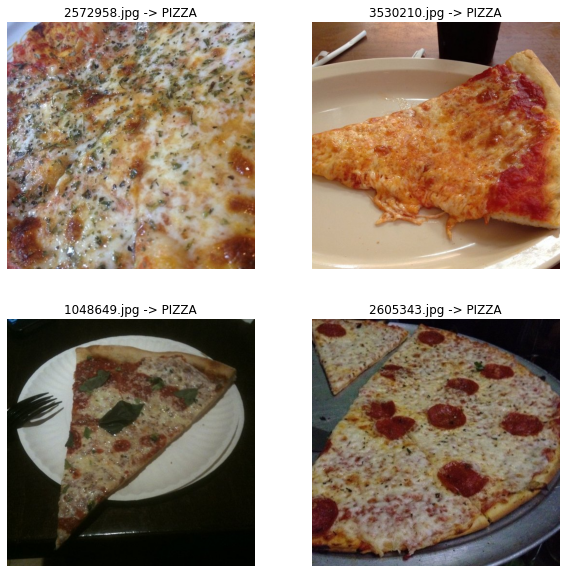

In [32]:
images = view_random_images('Data/Classification/pizza_steak/train', 'pizza', 4, (2,2))

**Note**: As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to scale (also referred to as normalize) their pixel values by dividing the image arrays by 255 (since 255 is the maximum pixel value)

## An end-to-end example

Lets build a convolutional neural network to find patterns in our images. More specifically we need a way to:
* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess the data (get all the pixel values between 0 and 1 also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# Setup paths to our data directories
train_dir = 'Data/Classification/pizza_steak/train'
test_dir = 'Data/Classification/pizza_steak/test'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                             batch_size = 32,
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             seed = 42
                                             )

valid_data = valid_datagen.flow_from_directory(test_dir,
                                             batch_size = 32,
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             seed = 42
                                             )

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)

model_1 = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = "relu", input_shape = (224,224,3), name = "input_layer"),
        tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = "relu", name = "conv_layer_1"),
        tf.keras.layers.MaxPool2D(pool_size=2, padding = "valid", name = "max_pool_layer_1"),
        tf.keras.layers.Conv2D(10, 3, activation = "relu", name = "conv_layer_2"),
        tf.keras.layers.Conv2D(10, 3, activation = "relu", name = "conv_layer_3"),
        tf.keras.layers.MaxPool2D(2, padding = "valid", name = "max_pool_layer_2"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer")
    ]
)

# Compile our CNN
model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    metrics = ['accuracy']
)

# Fit the model
history_1 = model_1.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data)
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 11s 216ms/step - loss: 0.6102 - accuracy: 0.6533
Epoch 2/5
47/47 [==============================] - 5s 97ms/step - loss: 0.4342 - accuracy: 0.8020
Epoch 3/5
47/47 [==============================] - 5s 100ms/step - loss: 0.3784 - accuracy: 0.8287
Epoch 4/5
47/47 [==============================] - 5s 100ms/step - loss: 0.3418 - accuracy: 0.8620
Epoch 5/5
47/47 [==============================] - 5s 97ms/step - loss: 0.3045 - accuracy: 0.8907


In [34]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Conv2D)        (None, 222, 222, 10)      280       
                                                                 
 conv_layer_1 (Conv2D)       (None, 220, 220, 10)      910       
                                                                 
 max_pool_layer_1 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv_layer_2 (Conv2D)       (None, 108, 108, 10)      910       
                                                                 
 conv_layer_3 (Conv2D)       (None, 106, 106, 10)      910       
                                                                 
 max_pool_layer_2 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                 

**Practice Exercise:** Go through the [CNN explainer website](https://poloclub.github.io/cnn-explainer)

## Using the same model as before

Lets replicate the model we've built in a previous section to see if it works with our image data.

In [35]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the Tensorflow Playground model
model_2 = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape = (224,224,3), name = "flatten_layer"),
        tf.keras.layers.Dense(4, activation = "relu", name = "hidden_layer_1"),
        tf.keras.layers.Dense(4, activation = "relu", name = "hidden_layer_2"),
        tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer")
    ], name = "model_2"
)

# Compile the model
model_2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_2 = model_2.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = valid_data,
    validation_steps = len(valid_data)
)

Epoch 1/5
47/47 [==============================] - 7s 152ms/step - loss: 1.2509 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 6s 128ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 5s 101ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 5s 97ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 5s 111ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [36]:
# Get a summary of model_2
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 150528)            0         
                                                                 
 hidden_layer_1 (Dense)      (None, 4)                 602116    
                                                                 
 hidden_layer_2 (Dense)      (None, 4)                 20        
                                                                 
 output_layer (Dense)        (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Whut! Even with a greater number of trainable parameters, the performance is bad. This is attributable to the advantage that CNNs have namely it utilizes the concept of spatial locality to alter its weights in a manner to capture features of interests in the image.

In [37]:
# Set the random seed
tf.random.set_seed(42)

# Create the model (same as above but lets step it up a notch)
model_3 = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape = (224,224,3), name = "flatten_layer"),
        tf.keras.layers.Dense(100, activation = "relu", name = "hidden_layer_1"),
        tf.keras.layers.Dense(100, activation = "relu", name = "hidden_layer_2"),
        tf.keras.layers.Dense(100, activation = "relu", name = "hidden_layer_3"),
        tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer")
    ], name = "model_3"
)

# Compile the model
model_3.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_model_3 = model_3.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = valid_data,
    validation_steps = len(valid_data)
)

Epoch 1/5
47/47 [==============================] - 7s 140ms/step - loss: 2.8651 - accuracy: 0.6340 - val_loss: 0.6452 - val_accuracy: 0.7660
Epoch 2/5
47/47 [==============================] - 6s 136ms/step - loss: 0.6992 - accuracy: 0.7287 - val_loss: 0.5407 - val_accuracy: 0.7720
Epoch 3/5
47/47 [==============================] - 6s 134ms/step - loss: 0.5436 - accuracy: 0.7547 - val_loss: 0.6784 - val_accuracy: 0.7100
Epoch 4/5
47/47 [==============================] - 6s 135ms/step - loss: 0.6006 - accuracy: 0.7320 - val_loss: 0.4482 - val_accuracy: 0.7960
Epoch 5/5
47/47 [==============================] - 6s 133ms/step - loss: 0.4563 - accuracy: 0.7980 - val_loss: 0.4309 - val_accuracy: 0.8020


In [38]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 150528)            0         
                                                                 
 hidden_layer_1 (Dense)      (None, 100)               15052900  
                                                                 
 hidden_layer_2 (Dense)      (None, 100)               10100     
                                                                 
 hidden_layer_3 (Dense)      (None, 100)               10100     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


Whoa! 15 million parameters for the same kind of accuracy! That speaks volumes about the efficacy of CNNs

## Binary Classification: Let's break it down

1. Become one with the data (visualize, visualize, visualize)
2. Preprocess the data (prepare it for the model, the main step here was scaling/normalizing)
3. Created the model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model (try to beat our baseline)
7. Repeat until satisfied.

### 1. Become one with the data

Image Shape: (512, 512, 3)
Image Shape: (512, 382, 3)
Image Shape: (384, 512, 3)
################################################################################
Image Shape: (384, 512, 3)
Image Shape: (512, 512, 3)
Image Shape: (512, 512, 3)


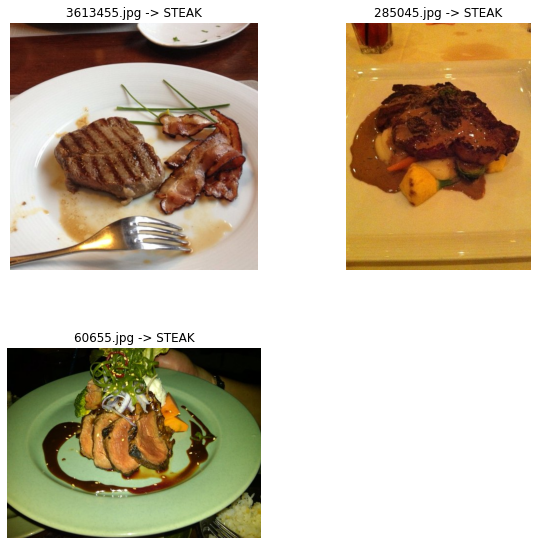

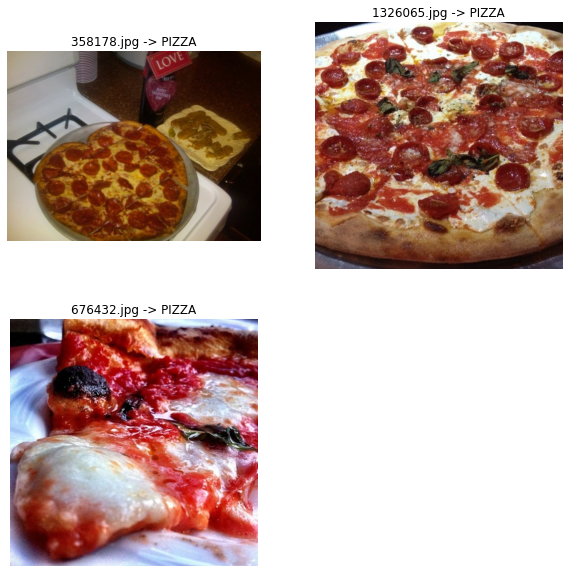

In [39]:
# Visualize the data
steak_img = view_random_images("Data/Classification/pizza_steak/train", "steak", 3, (2,2))
print("#"*80)
pizza_img = view_random_images("Data/Classification/pizza_steak/train", "pizza", 3, (2,2))

# 2. Preprocess the data (prepare it for a model)

In [40]:
# Define the directory dataset paths

train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Our next step is to turn our data into **batches**.

A batch is a small subset of data. Rather than look at all ~10,000 images at one time, a model might only look at 32 at a time.

It does this for a couple of reasons:
1. 10,000 images (or more) might not fit into the memory of your processor (GPU)
2. Trying to learn the patterns in 10,000 images in one hit might result in the model not being able to learn very well.

Why 32 then?
Because 32 is good for your health... https://twitter.com/ylecun/status/989610208497360896?s=20

In [41]:
!nvidia-smi

Fri Jul  1 09:38:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   63C    P8     7W /  N/A |   4823MiB /  6144MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [42]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [43]:
train_data = train_datagen.flow_from_directory(
    directory = "Data/Classification/pizza_steak/train", # Target directory of images
    target_size = (224,224), # Target size of images (height, width)
    class_mode = "binary", # type of data you're working with ("categorical", "binary", "sparse", "input" or "None"; default: "categorical")
    batch_size = 32, # size of minibatches to load data into
    seed = 42,
    subset = 'training'
)

valid_data = train_datagen.flow_from_directory(
    directory = "Data/Classification/pizza_steak/train", # Target directory of images
    target_size = (224,224), # Target size of images (height, width)
    class_mode = "binary", # type of data you're working with ("categorical", "binary", "sparse", "input" or "None"; default: "categorical")
    batch_size = 32, # size of minibatches to load data into
    seed = 42,
    subset = 'validation'
)

test_data = test_datagen.flow_from_directory(
    directory = "Data/Classification/pizza_steak/test",
    target_size = (224, 224),
    class_mode = "binary",
    batch_size = 32,
    seed = 42
)

Found 1200 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [44]:
# Get a sample of train data
images, labels = train_data.next()
images.shape, labels.shape

((32, 224, 224, 3), (32,))

In [45]:
# How many batches are there
len(train_data)

38

In [46]:
# Get the first 2 images
images[0:2].shape

(2, 224, 224, 3)

In [47]:
labels

array([1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
      dtype=float32)

## 3. Create a CNN Model (start with a baseline)

A baseline is a relatively simple model or existing result that you setup when beginning a machine learning experiment and then as you keep experimenting you try to beat the baseline.

**Note:** In deep learning, there is almost an infinite amount of architectures you could create. So one of the best ways to get started is to start with something simple and see if it works on your data and then introduce complexity as required (eg look at which current model is performing best in the field for your problem).

In [48]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation
from tensorflow.keras import Sequential

In [49]:
# Create the model (this will be our baseline, a layer convolutional neural network)

model_4 = Sequential(
    [
        Conv2D(filters = 10, kernel_size = 3, strides = 1, padding = "valid", activation = "relu", input_shape = (224,224,3), name = "input_layer"),
        Conv2D(filters = 10, kernel_size = 3, strides = 1, padding = "valid", activation = "relu", name = "hidden_layer_1"),
        Conv2D(filters = 10, kernel_size = 3, strides = 1, padding = "valid", activation = "relu", name = "hidden_layer_2"),
        Flatten(),
        Dense(1, activation = 'sigmoid') # output layer (working with binary classification)
    ]
)

# Compile the model
model_4.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history = model_4.fit(
            train_data,
            epochs = 5,
            steps_per_epoch = len(train_data),
            validation_data = valid_data,
            validation_steps = len(valid_data)
        )

Epoch 1/5
38/38 [==============================] - 7s 156ms/step - loss: 0.8358 - accuracy: 0.7342 - val_loss: 0.5424 - val_accuracy: 0.7467
Epoch 2/5
38/38 [==============================] - 5s 131ms/step - loss: 0.3795 - accuracy: 0.8392 - val_loss: 0.5271 - val_accuracy: 0.7567
Epoch 3/5
38/38 [==============================] - 5s 136ms/step - loss: 0.2685 - accuracy: 0.9058 - val_loss: 0.6309 - val_accuracy: 0.7500
Epoch 4/5
38/38 [==============================] - 5s 122ms/step - loss: 0.1047 - accuracy: 0.9717 - val_loss: 0.6298 - val_accuracy: 0.7533
Epoch 5/5
38/38 [==============================] - 4s 116ms/step - loss: 0.0330 - accuracy: 0.9917 - val_loss: 1.1248 - val_accuracy: 0.7167


Looks like a classic case of overfitting!

## Breakdown of a Conv2D layer

Example code: tf.keras.layers.Conv2D(filters = 10, kernel_size = (3,3), strides = (1,1), padding = "same")
Example 2(same as above): tf.keras.layers.Conv2D(filters=10, kernel_size=3, strides=1, padding = "same")

|Hyperparameter name|What does it do?|Typical values|
|-------------------|----------------|--------------|
|Filters|Decides how many filters should pass over an input tensor (eg sliding windows over an image)|10, 32, 64, 128 (higher values lead to more complex models)|
|Kernel size (also called filter size)|Determines the shape of the filters (sliding windows) over the output|3, 5, 7 (lowers values learn smaller features, higher values learn larger features)|
|Padding|Pads the target tensor with zeroes (if "same") to preserve input shape. Or leaves in the target tensor as is (if "valid"), lowering output shape|"same" or "valid"|
|Strides|The number of steps a filter takes across an image at a time (eg if `strides = 1`, a filter moves across an image 1 pixel at a time)|1 (default), 2|

In [50]:
model_1.evaluate(test_data)

16/16 [==============================] - 2s 103ms/step - loss: 0.2946 - accuracy: 0.8860


[0.2946016192436218, 0.8859999775886536]

In [51]:
model_4.evaluate(test_data)

16/16 [==============================] - 2s 76ms/step - loss: 0.6117 - accuracy: 0.8020


[0.6117287874221802, 0.8019999861717224]

Looks like we still have a long way to go from the baseline

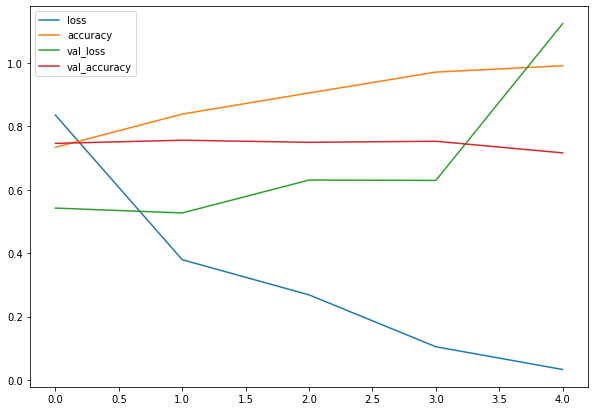

In [53]:
# Lets plot the train and validation curves for model_4
pd.DataFrame(history.history).plot(figsize=(10,7));

And we see that around the second epoch, our model has started to overfit on train data resulting in the loss actually increasing for validation data

In [59]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history["loss"]
    accuracy = history.history["accuracy"]
    
    val_loss = history.history["val_loss"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(loss))
    
    # plt.subplot(1,2,1)
    plt.figure()
    #Plot loss
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "validation_loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.legend()

    # plt.subplot(1,2,2)
    plt.figure()
    #Plot accuracy
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "validation_accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.legend()

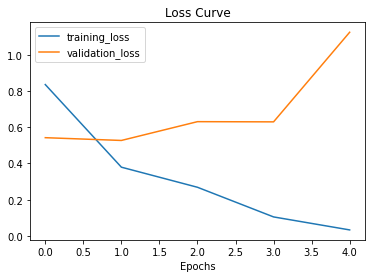

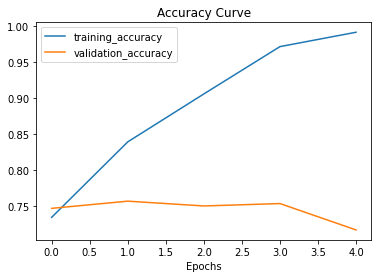

In [60]:
plot_loss_curves(history)

Overfitting clearly!

## 6. Adjust the model parameters

Fitting a machine learning model comes in 3 steps:

0. Create a baseline
1. Beat the baseline by overfitting a larger model
2. Reduce overfitting

Ways to induce overfitting:
* Increase the number of conv layers
* Increase the number of conv filters
* Add another dense layer to the output of our flattened layer

Reduce overfitting:
* Add data augmentation
* Add regularisation layers (such as MaxPool2D)
* Add more data...

In [66]:
# Set seed
tf.random.set_seed(42)

# Create the model (this is going to be our new baseline)

model_5 = Sequential(
    [
        Conv2D(10, 3, activation = "relu", strides = 1, input_shape = (224,224,3), name = "input_layer"),
        MaxPooling2D(pool_size=2, name = "max_pool_1"),
        Conv2D(10,3, activation = "relu", strides = 1, name = "hidden_layer_1"),
        MaxPooling2D(pool_size=2, name = "max_pool_2"),
        Conv2D(10, 3, activation = "relu", strides = 1, padding = "valid", name = "hidden_layer_2"),
        MaxPooling2D(pool_size=2, name = "max_pool_3"),
        Flatten(name = "flatten_layer"),
        Dense(1, activation = "sigmoid", name = "output_layer")
    ], name = "model_5"
)

model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Conv2D)        (None, 222, 222, 10)      280       
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 111, 111, 10)      0         
                                                                 
 hidden_layer_1 (Conv2D)     (None, 109, 109, 10)      910       
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 54, 54, 10)        0         
                                                                 
 hidden_layer_2 (Conv2D)     (None, 52, 52, 10)        910       
                                                                 
 max_pool_3 (MaxPooling2D)   (None, 26, 26, 10)        0         
                                                                 
 flatten_layer (Flatten)     (None, 6760)              0   

In [67]:
# Compile the model
model_5.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_5 = model_5.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = valid_data,
    validation_steps = len(valid_data)
)

Epoch 1/5
38/38 [==============================] - 5s 104ms/step - loss: 0.6249 - accuracy: 0.6542 - val_loss: 0.5266 - val_accuracy: 0.7367
Epoch 2/5
38/38 [==============================] - 4s 97ms/step - loss: 0.4944 - accuracy: 0.7842 - val_loss: 0.4878 - val_accuracy: 0.7867
Epoch 3/5
38/38 [==============================] - 4s 95ms/step - loss: 0.4184 - accuracy: 0.8192 - val_loss: 0.5169 - val_accuracy: 0.7633
Epoch 4/5
38/38 [==============================] - 4s 95ms/step - loss: 0.4114 - accuracy: 0.8142 - val_loss: 0.4681 - val_accuracy: 0.7767
Epoch 5/5
38/38 [==============================] - 4s 95ms/step - loss: 0.3668 - accuracy: 0.8400 - val_loss: 0.4506 - val_accuracy: 0.8100


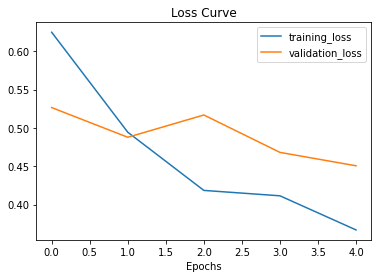

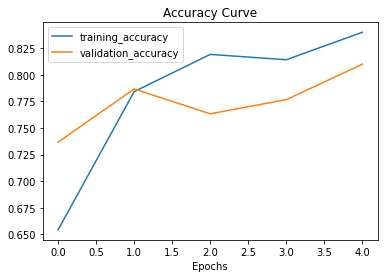

In [68]:
plot_loss_curves(history_5)

Yeah shit. This isn't what we wanted. Its overfitting again. Although atleast this time around it isn't as bad as it was earlier.

## Opening our bag of tricks and finding data augmentation

In [89]:
# Create ImageDataGenerator training instance with data augmentation

train_datagen_augmented = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 0.2, # how much do you want to rotate, shear and so on
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.3,
    horizontal_flip = True,
    validation_split = 0.2
)

valid_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

# To prevent augmentation on validation set, we need to have the valid_datagen separate and set the same seed in order to get a perfect split of the train directory
train_data_augmented = train_datagen_augmented.flow_from_directory(
    directory = "Data/Classification/pizza_steak/train", # Target directory of images
    target_size = (224,224), # Target size of images (height, width)
    class_mode = "binary", # type of data you're working with ("categorical", "binary", "sparse", "input" or "None"; default: "categorical")
    batch_size = 32, # size of minibatches to load data into
    seed = 42,
    subset = 'training'
)

train_data = train_datagen.flow_from_directory(
    directory = "Data/Classification/pizza_steak/train", # Target directory of images
    target_size = (224,224), # Target size of images (height, width)
    class_mode = "binary", # type of data you're working with ("categorical", "binary", "sparse", "input" or "None"; default: "categorical")
    batch_size = 32, # size of minibatches to load data into
    seed = 42,
    subset = 'training'
)

valid_data = valid_datagen.flow_from_directory(
    directory = "Data/Classification/pizza_steak/train", # Target directory of images
    target_size = (224,224), # Target size of images (height, width)
    class_mode = "binary", # type of data you're working with ("categorical", "binary", "sparse", "input" or "None"; default: "categorical")
    batch_size = 32, # size of minibatches to load data into
    seed = 42,
    subset = 'validation'
)

test_data = test_datagen.flow_from_directory(
    directory = "Data/Classification/pizza_steak/test",
    target_size = (224, 224),
    class_mode = "binary",
    batch_size = 32,
    seed = 42
)

Found 1200 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


**Note:** Data augmentation is usually only performed on the training data. Using `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but are modified as they're loaded into the model

## Improving a model
|Method to reduce overfitting|What does it do?|
|----------------------------|----------------|
|More data|Give a model more of a chance to learn patterns between samples (eg if a model is performing poorly on images of pizza, show it more images of pizza)|
|Data augmentation|Increase the diversity of your training dataset without collecting more data (eg take your photos of pizza and randomly rotate them 30&deg;). Increased diversity forces a model to learn more generalisation patterns.|
|Better data|Not all data samples are created equally. Removing poor samples from or adding better samples to your dataset can improve your model's performance|
|Use transfer learning|Take a model's pre-learned patterns from one problem and tweak them to suit your own problem. For example, take a model trained on pictures of cars to recognise pictures of trucks|

Finally...let's visualise some augmented data!!!

In [90]:
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # note: labels aren't augmented...just images

showing image number: 16


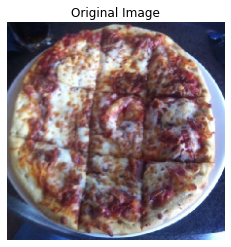

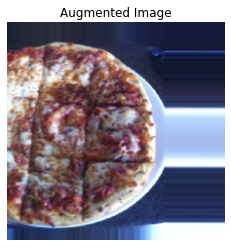

In [91]:
# Show original image and augmented image
import random
random_number = random.randint(0,31) # our batch sizes are 32...
print(f"showing image number: {random_number}")

plt.imshow(images[random_number]);
plt.title(f"Original Image");
plt.axis(False);

plt.figure();
plt.imshow(augmented_images[random_number]);
plt.title("Augmented Image");
plt.axis(False);